In [5]:
# 1. 데이터 불러오기
import pandas as pd

# 로컬에 저장된 CSV 파일 불러오기
data = pd.read_csv("netflix_titles.csv")

# 데이터 sample 확인
print("Data Sample:")
print(data.head())

Data Sample:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24,

In [7]:
# 1-1. EDA: Descriptive 통계

# 기술 통계 확인
print("\nDescriptive Statistics:")
print(data.describe())


Descriptive Statistics:
       release_year
count   8807.000000
mean    2014.180198
std        8.819312
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2019.000000
max     2021.000000


In [8]:
# 범주형 변수의 값 분포 확인
print("\nType Distribution:")
print(data["type"].value_counts())
print("\nRating Distribution:")
print(data["rating"].value_counts())


Type Distribution:
type
Movie      6131
TV Show    2676
Name: count, dtype: int64

Rating Distribution:
rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64


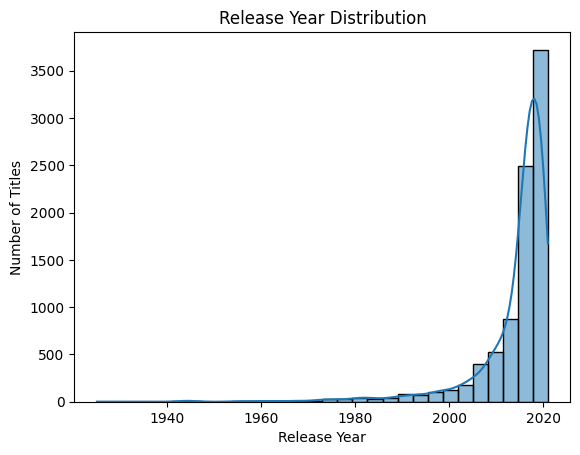

In [9]:
# 1-2. EDA: 변수 시각화

# 시각화를 위한 모듈 선언
import seaborn as sns
import matplotlib.pyplot as plt

# 개봉 연도 분포 시각화
sns.histplot(data["release_year"], bins=30, kde=True)
plt.title("Release Year Distribution")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.show()

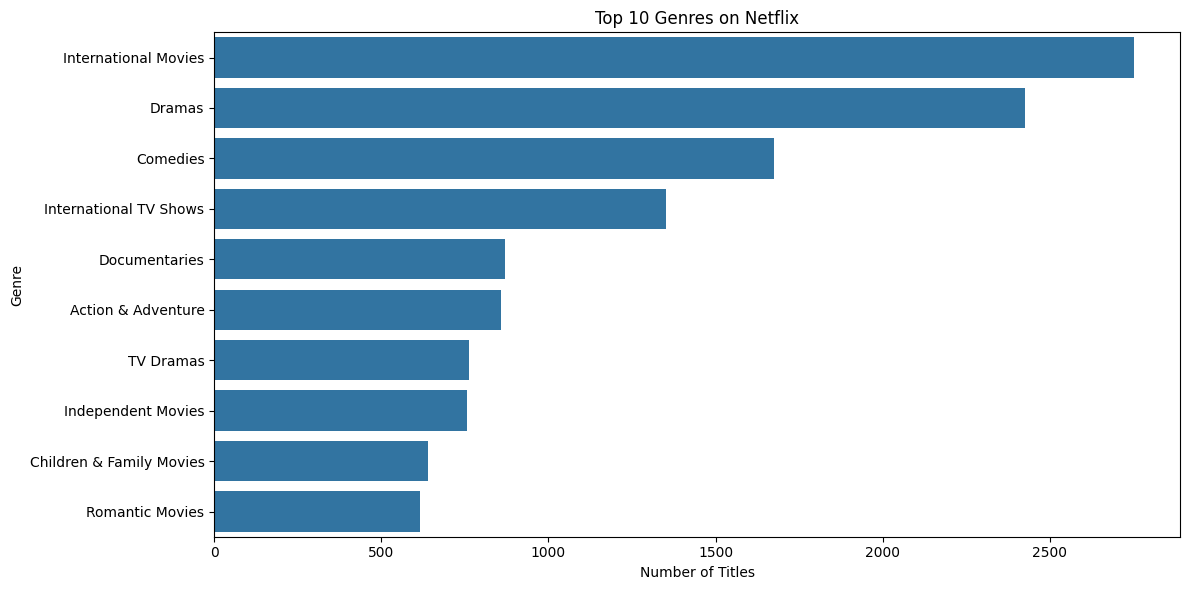

In [10]:
# 장르별 작품 수 계산

# collections 모듈 선언
from collections import Counter

# 장르별 작품 수 계산 및 시각화
data["genre_list"] = data["listed_in"].str.split(", ")

# 장르별 제목 수 세기
genre_counts = Counter()
for genres in data["genre_list"].dropna():
    genre_counts.update(genres)

# 상위 10개 장르
top_genres = genre_counts.most_common(10)
genres, counts = zip(*top_genres)

# 상위 10개 장르 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(genres))
plt.title("Top 10 Genres on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

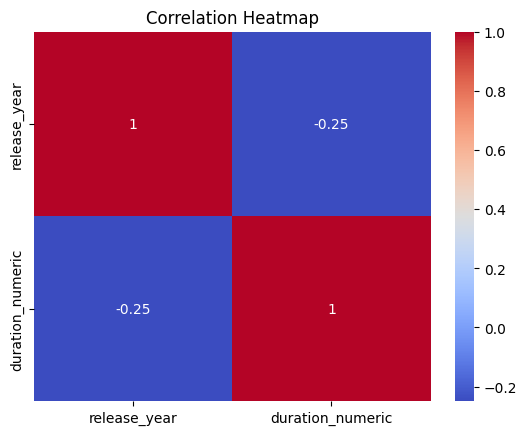

In [12]:
# 1-3. EDA: 상관관계 분석

# 작품 길이를 숫자형으로 변환 (정규 표현식 수정)
data["duration_numeric"] = data["duration"].str.extract(r"(\d+)").astype(float)

# 개봉 연도와 작품 길이 간의 상관관계 분석을 위한 데이터 준비 (NaN 값 제거)
numeric_data = data[["release_year", "duration_numeric"]].dropna()

# NaN 값 제거 후 상관관계 분석
correlation = numeric_data.corr()

# NaN 값이 없는 상관관계 heatmap 시각화
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [14]:
# 2. 데이터 전처리 및 학습 데이터 준비

# 학습 및 전처리 모듈 선언
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 사용할 열 선택
features = data[["type", "release_year", "duration_numeric"]]
target = data["rating"]

# 결측치가 있는 행 제거
features = features.dropna()
target = target.loc[features.index]

# 범주형 변수 인코딩
le_type = LabelEncoder()
features["type"] = le_type.fit_transform(features["type"])

le_rating = LabelEncoder()
target_encoded = le_rating.fit_transform(target)

# 클래스 불균형 처리
target_series = pd.Series(target_encoded, index=features.index)
rating_counts = target_series.value_counts()
common_ratings = rating_counts[rating_counts >= 50].index
filtered_indices = target_series.isin(common_ratings)

# 필터링된 특징과 목표 변수로 업데이트
features = features[filtered_indices].reset_index(drop=True)
target = target_series[filtered_indices].reset_index(drop=True)

# 학습용 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, stratify=target
)

In [15]:
# 3. 모델 학습

# 모델 학습을 위한 모듈 선언
from sklearn.ensemble import RandomForestClassifier

# 모델 학습
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
# 4. 모델 평가 및 성능 분석

# 성능 분석을 위한 모듈 선언
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

# 모델 예측
y_pred = model.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Accuracy
print("\nAccuracy:", accuracy_score(y_test, y_pred))

# Precision
print("Precision:", precision_score(y_test, y_pred, average="weighted", zero_division=1))

# Recall
print("Recall:", recall_score(y_test, y_pred, average="weighted", zero_division=1))

# F1-Score
print("F1-Score:", f1_score(y_test, y_pred, average="weighted", zero_division=1))

Confusion Matrix:
[[  0   0   1   4   3   0  10   0   0   2]
 [  3   5   9  15  16   0  21   2   1   0]
 [  0   6  19  28  25   0  41   3   0   0]
 [  3   6  16  39  46   0  80   9   0   1]
 [  3   4  19  32 169   6 284  18   2   3]
 [  0   0   0   0  12   1  34   7   0   1]
 [ 10   4  20  36 127   7 555  24   4  15]
 [  1   4   9  11  63   1 112   8   3   4]
 [  0   1   0   1  14   1  43   3  10   4]
 [  0   0   0   1  14   0  50   7   2   9]]

Accuracy: 0.37265660722450844
Precision: 0.32513023006308917
Recall: 0.37265660722450844
F1-Score: 0.3326895426691113


In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00        20
           3       0.17      0.07      0.10        72
           4       0.20      0.16      0.18       122
           5       0.23      0.20      0.21       200
           6       0.35      0.31      0.33       540
           7       0.06      0.02      0.03        55
           8       0.45      0.69      0.55       802
           9       0.10      0.04      0.05       216
          10       0.45      0.13      0.20        77
          11       0.23      0.11      0.15        83

    accuracy                           0.37      2187
   macro avg       0.22      0.17      0.18      2187
weighted avg       0.33      0.37      0.33      2187

